In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob as gb
import keras
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import requests
from io import BytesIO
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from PIL import Image, ImageDraw, ImageFont
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
import cv2
from sklearn.metrics import log_loss

from matplotlib.image import imread
from pathlib import Path
from tqdm import tqdm
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import random 
from keras.layers import Input, Add, Dense, GlobalAvgPool2D
import tensorflow as tf
import matplotlib.image as mpimg
from keras import regularizers
from tensorflow.keras.models import Model
from keras.layers import Input, Add, Dense, Concatenate, AvgPool2D, Dropout, BatchNormalization, GlobalAveragePooling2D
import seaborn as sns
%matplotlib inline

# Food images

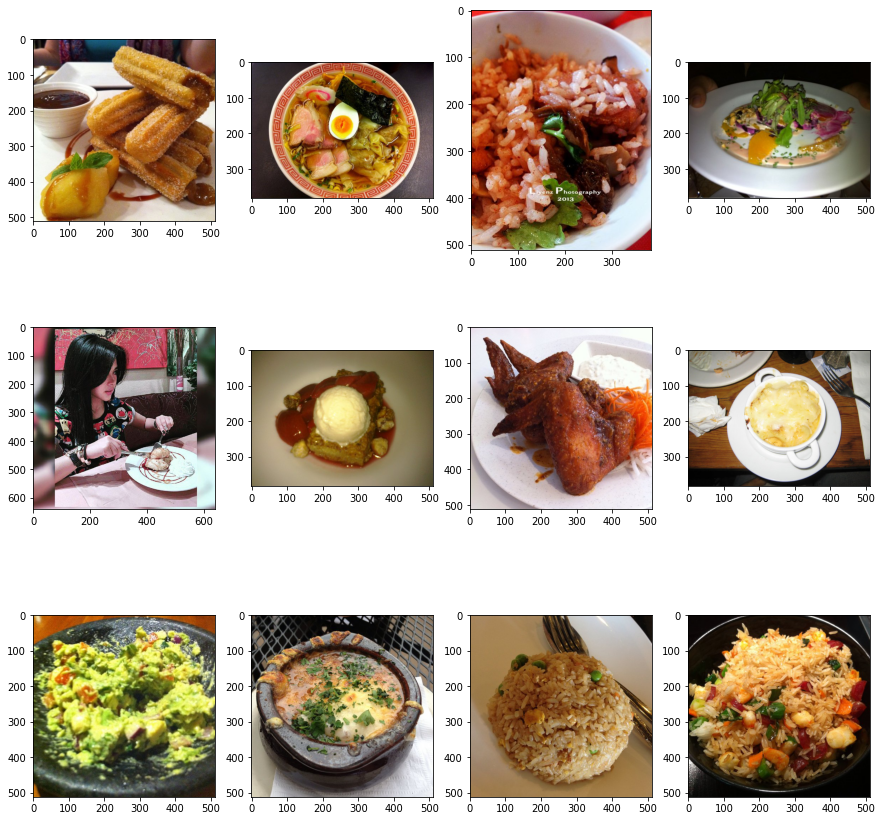

In [2]:
plt.figure(figsize=(15,15))
food_images="../input/food5k-image-dataset/training/food/"
for i in range(12):
    file=random.choice(os.listdir(food_images))
    food_image_path=os.path.join(food_images,file)
    img=mpimg.imread(food_image_path)
    ax=plt.subplot(3,4,i+1)
    plt.imshow(img)
plt.show()

# Non Food images

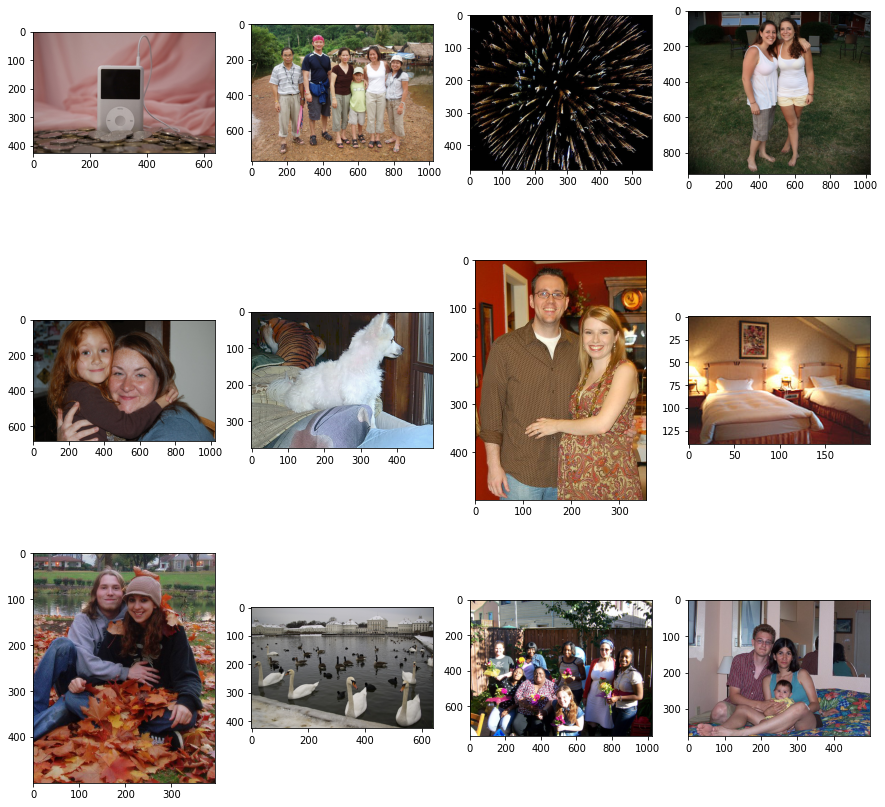

In [3]:
plt.figure(figsize=(15,15))
non_food_images="../input/food5k-image-dataset/training/non_food/"
for i in range(12):
    file=random.choice(os.listdir(non_food_images))
    non_food_image_path=os.path.join(non_food_images,file)
    img=mpimg.imread(non_food_image_path)
    ax=plt.subplot(3,4,i+1)
    plt.imshow(img)
plt.show()

# Read Data

In [4]:
image_path=Path("../input/food5k-image-dataset/training/")
img_path="../input/food5k-image-dataset/training/"

In [5]:
label_name=["Food","Non_Food"]

In [6]:
image_size=(224,224)

In [7]:
class_names = os.listdir(image_path)
print(class_names)
print("Number of classes : {}".format(len(class_names)))

['food', 'non_food']
Number of classes : 2


In [8]:
numberof_images={}
for class_name in class_names:
    numberof_images[class_name]=len(os.listdir(img_path+"/"+class_name))
images_each_class=pd.DataFrame(numberof_images.values(),index=numberof_images.keys(),columns=["Number of images"])
images_each_class

Number of images
food                  1500
non_food              1500

# Train DataFrame

In [9]:
train_data_path=Path(r"../input/food5k-image-dataset/training/")
image_data_path=list(train_data_path.glob(r"**/*.jpg"))
train_label_path=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],image_data_path))
final_train_data=pd.DataFrame({"image_data":image_data_path,"label":train_label_path}).astype("str")
final_train_data=final_train_data.sample(frac=1).reset_index(drop=True)


In [10]:
final_train_data.head()

image_data     label
0  ../input/food5k-image-dataset/training/food/23...      food
1  ../input/food5k-image-dataset/training/food/70...      food
2  ../input/food5k-image-dataset/training/food/12...      food
3  ../input/food5k-image-dataset/training/food/13...      food
4  ../input/food5k-image-dataset/training/non_foo...  non_food

# Valid DataFrame

In [11]:
valid_data_path=Path(r"../input/food5k-image-dataset/validation/")
image_data_path=list(valid_data_path.glob(r"**/*.jpg"))
valid_label_path=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],image_data_path))
final_valid_data=pd.DataFrame({"image_data":image_data_path,"label":valid_label_path}).astype("str")
final_valid_data=final_valid_data.sample(frac=1).reset_index(drop=True)

In [12]:
final_valid_data.head()

image_data     label
0  ../input/food5k-image-dataset/validation/non_f...  non_food
1  ../input/food5k-image-dataset/validation/non_f...  non_food
2  ../input/food5k-image-dataset/validation/non_f...  non_food
3  ../input/food5k-image-dataset/validation/food/...      food
4  ../input/food5k-image-dataset/validation/food/...      food

# Test DataFrame

In [13]:
test_data_path=Path(r"../input/food5k-image-dataset/evaluation/")
image_data_path=list(test_data_path.glob(r"**/*.jpg"))
test_label_path=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],image_data_path))
final_test_data=pd.DataFrame({"image_data":image_data_path,"label":test_label_path}).astype("str")
final_test_data=final_test_data.sample(frac=1).reset_index(drop=True)

In [14]:
final_test_data.head()

image_data     label
0  ../input/food5k-image-dataset/evaluation/food/...      food
1  ../input/food5k-image-dataset/evaluation/non_f...  non_food
2  ../input/food5k-image-dataset/evaluation/non_f...  non_food
3  ../input/food5k-image-dataset/evaluation/food/...      food
4  ../input/food5k-image-dataset/evaluation/non_f...  non_food

In [15]:
batch_size=30

In [16]:
traindata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,
                                                                    shear_range=0.2, horizontal_flip=True,validation_split=0.2,fill_mode='nearest')

validdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [17]:
train_data_generator=traindata_generator.flow_from_dataframe(dataframe=final_train_data,
                                                             x_col="image_data",
                                                             y_col="label",
                                                             batch_size=batch_size,
                                                             class_mode="categorical",
                                                             target_size=(224,224),
                                                             color_mode="rgb",
                                                             shuffle=True )

Found 3000 validated image filenames belonging to 2 classes.


In [18]:
valid_data_generator=validdata_generator.flow_from_dataframe(dataframe=final_valid_data,
                                                             x_col="image_data",
                                                             y_col="label",
                                                             batch_size=batch_size,class_mode="categorical",
                                                             target_size=(224,224),color_mode="rgb",shuffle=True )

Found 1000 validated image filenames belonging to 2 classes.


In [19]:
test_data_generator=testdata_generator.flow_from_dataframe(dataframe=final_test_data,
                                                           x_col="image_data",
                                                           y_col="label",
                                                           batch_size=batch_size,class_mode="categorical",
                                                           target_size=(224,224),color_mode="rgb",shuffle=False )

Found 1000 validated image filenames belonging to 2 classes.


In [20]:
class_dict = train_data_generator.class_indices
class_list = list(class_dict.keys())
class_list

['food', 'non_food']

In [21]:
train_number=train_data_generator.samples
valid_number=valid_data_generator.samples

# Create DenseNet121 Model

In [22]:

dense121_model= tf.keras.applications.densenet.DenseNet121(weights='imagenet',include_top=False, input_shape=(224,224, 3))
x= dense121_model.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x) 
x= Dense(512,activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x) 

x= Dropout(0.5)(x)
prediction= Dense(2, activation = 'softmax')(x)
model= Model(inputs= dense121_model.input, outputs= prediction)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# Train Model

In [23]:
tensor_board=TensorBoard(log_dir="logs")
check_point=ModelCheckpoint("denseNet121.h5",monitor="val_accuracy",mode="auto",verbose=1,save_best_only=True)

In [24]:
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",factor=0.3,patience=60,min_delta=0.001,mode="auto",verbose=1)

In [25]:
history= model.fit(train_data_generator, 
                   steps_per_epoch=train_number//batch_size, 
                   validation_data= valid_data_generator, 
                   validation_steps= valid_number//batch_size,
                   shuffle=True, 
                   
                   epochs =50, 
                   callbacks=[tensor_board,check_point,reduce_lr])

Epoch 1/50
100/100 [==============================] - 78s 652ms/step - loss: 0.5877 - accuracy: 0.8563 - val_loss: 409.8518 - val_accuracy: 0.5030

Epoch 00001: val_accuracy improved from -inf to 0.50303, saving model to denseNet121.h5
Epoch 2/50
100/100 [==============================] - 63s 625ms/step - loss: 0.5634 - accuracy: 0.8597 - val_loss: 3.1048 - val_accuracy: 0.7626

Epoch 00002: val_accuracy improved from 0.50303 to 0.76263, saving model to denseNet121.h5
Epoch 3/50
100/100 [==============================] - 59s 585ms/step - loss: 0.3768 - accuracy: 0.9153 - val_loss: 0.3791 - val_accuracy: 0.9202

Epoch 00003: val_accuracy improved from 0.76263 to 0.92020, saving model to denseNet121.h5
Epoch 4/50
100/100 [==============================] - 62s 622ms/step - loss: 0.3347 - accuracy: 0.9270 - val_loss: 0.4333 - val_accuracy: 0.8869

Epoch 00004: val_accuracy did not improve from 0.92020
Epoch 5/50
100/100 [==============================] - 62s 619ms/step - loss: 0.2970 - acc

# Accuracy Graph

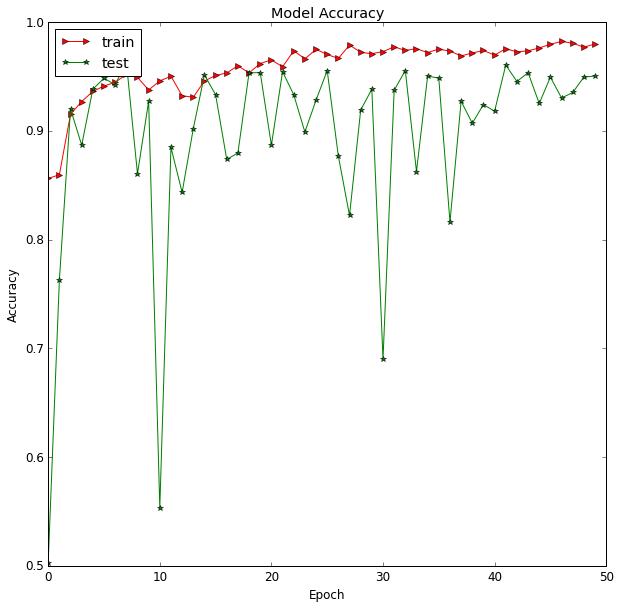

In [26]:

plt.figure(figsize=(10,10))
plt.style.use("classic")
plt.plot(history.history['accuracy'],marker=">",color="red")
plt.plot(history.history['val_accuracy'],marker="*",color="green")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss Graph

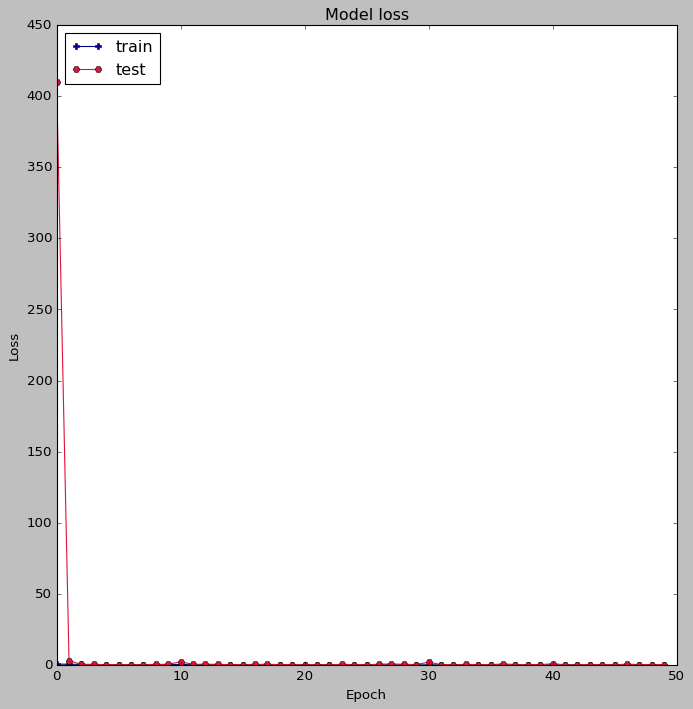

In [27]:
plt.figure(figsize=(10,10))
plt.style.use("classic")
plt.plot(history.history['loss'],marker="P",color="navy")
plt.plot(history.history['val_loss'],marker="H",color="crimson")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Prediction

In [28]:
prediction=model.predict(test_data_generator)
prediction=np.argmax(prediction,axis=1)
map_label=dict((m,n) for n,m in (test_data_generator.class_indices).items())
final_predict=pd.Series(prediction).map(map_label).values
y_test=list(final_test_data.label)

# ROC Curve

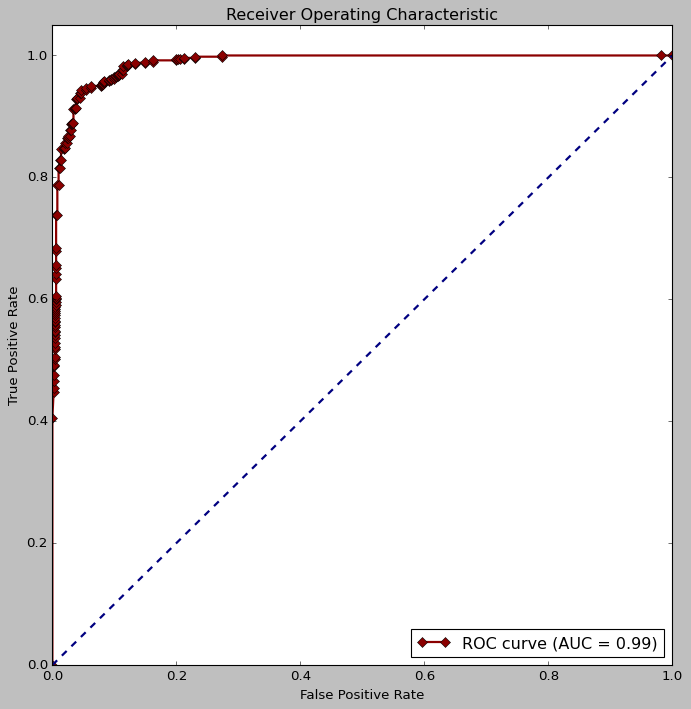

In [29]:
plt.figure(figsize=(10,10))
y_test_numeric = [0 if label == 'food' else 1 for label in y_test]


predicted_probabilities = model.predict(test_data_generator)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_numeric, predicted_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred', lw=2,marker="D", label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Roc Curve For Each Class

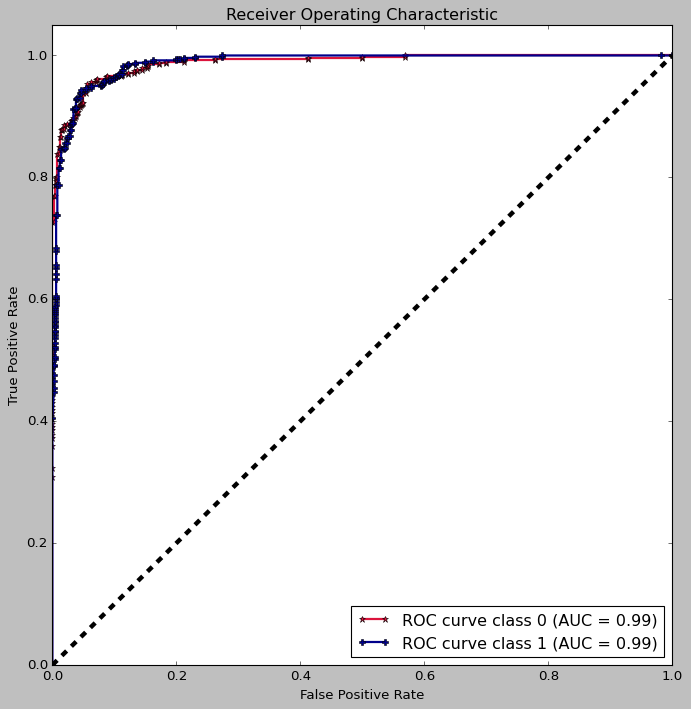

In [30]:
plt.figure(figsize=(10,10))
plt.style.use("classic")
num_class=2
true_numeric=np.array([0 if label=="food" else 1 for label in y_test])
predict_probability=np.zeros((len(y_test),num_class))
for class_index in range(num_class):
    predict_probability[:,class_index]=model.predict(test_data_generator)[:,class_index]

fpr=dict()
tpr=dict()
thresholds=dict()
roc_auc=dict()
colors = ["crimson", "darkblue"]
markers=["*","P"]
# Compute ROC curve and AUC for each class

for class_index in range(num_class):
    fpr[class_index],tpr[class_index],thresholds[class_index]=roc_curve((true_numeric==class_index).astype(int),predict_probability[:,class_index])
    roc_auc[class_index]=auc(fpr[class_index],tpr[class_index])
    
    plt.plot(fpr[class_index],tpr[class_index], lw=2,color=colors[class_index],marker=markers[class_index],label='ROC curve class %d (AUC = %0.2f)' % (class_index, roc_auc[class_index]))

    
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Precision-Recall Curve

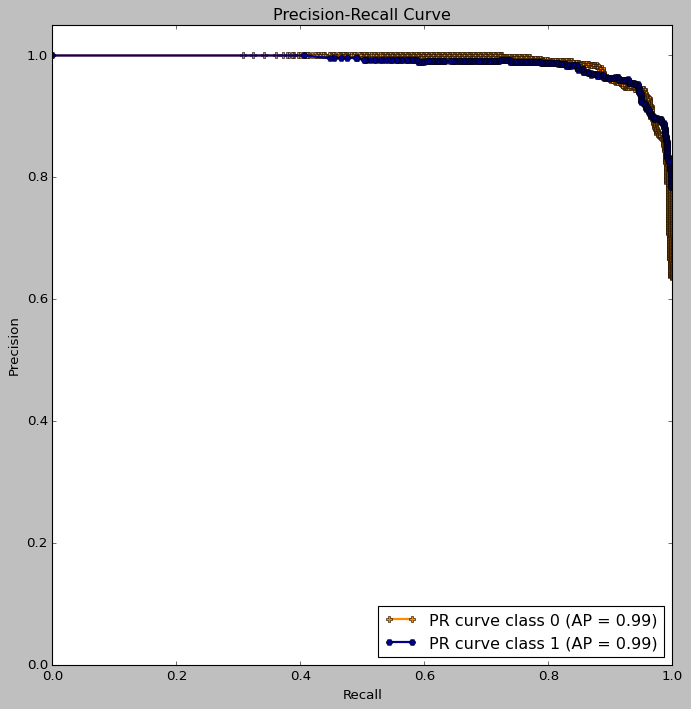

In [31]:
plt.figure(figsize=(10,10))
plt.style.use("classic")
precision = dict()
recall = dict()
average_precision = dict()
colors=["darkorange","darkblue"]
markers=["P","H"]

for class_index in range(num_class):
    precision[class_index], recall[class_index], _ = precision_recall_curve((true_numeric == class_index).astype(int), predict_probability[:, class_index])
    average_precision[class_index] = average_precision_score((true_numeric == class_index).astype(int), predict_probability[:, class_index])

    plt.plot(recall[class_index],precision[class_index],lw=2,color=colors[class_index],marker=markers[class_index],label='PR curve class %d (AP = %0.2f)' % (class_index, average_precision[class_index]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()


# Confusion Matrix

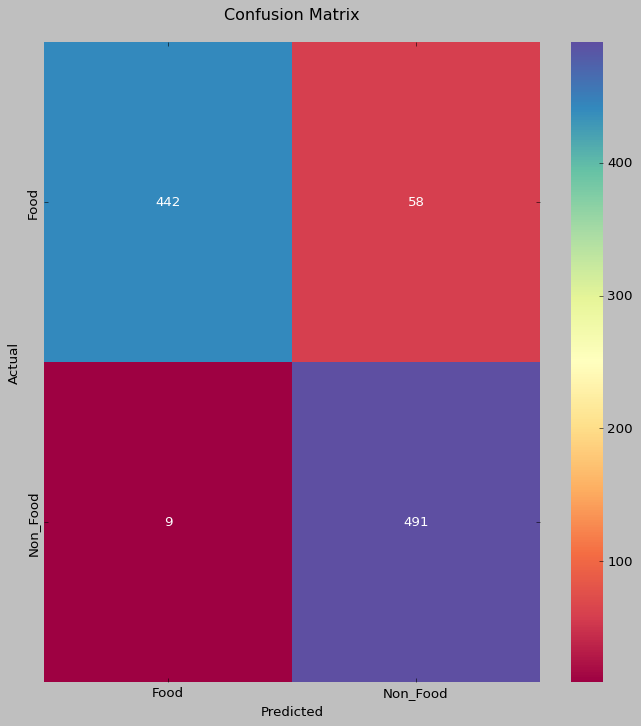

In [32]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test,final_predict)
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="Spectral",xticklabels=label_name,yticklabels=label_name)
plt.title("Confusion Matrix\n")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# Classification Report

In [33]:
print(classification_report(y_test,final_predict))

              precision    recall  f1-score   support

        food       0.98      0.88      0.93       500
    non_food       0.89      0.98      0.94       500

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



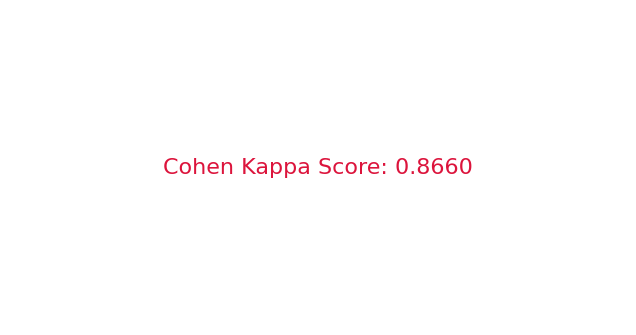

In [34]:

from sklearn.metrics import cohen_kappa_score

plt.figure(figsize=(10, 5), facecolor="white")
kappa = cohen_kappa_score(y_test, final_predict)
plt.plot([])
plt.text(0, 0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=20, ha='center', va='center', color="crimson")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


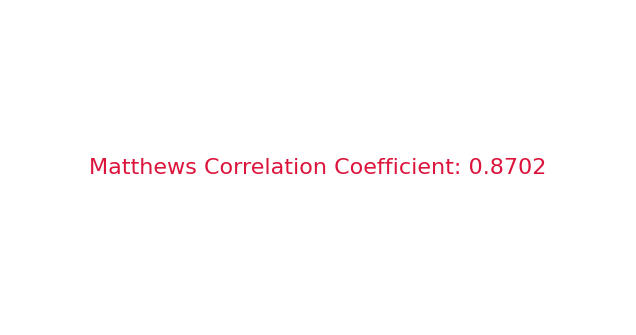

In [35]:

plt.figure(figsize=(10, 5), facecolor="white")
mcc = matthews_corrcoef(y_test, final_predict)

plt.plot([])
plt.text(0, 0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=20, ha='center', va='center', color="crimson")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


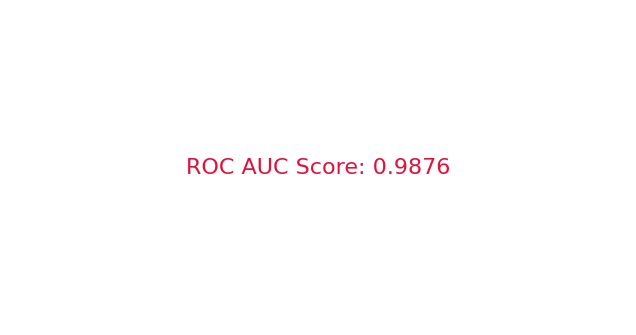

In [36]:

pred=model.predict(test_data_generator)
predicted_probabilities = pred[:, 1]

plt.figure(figsize=(10, 5), facecolor="white")
roc_auc = roc_auc_score(y_test, predicted_probabilities)

plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=20, ha='center', va='center', color="crimson")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


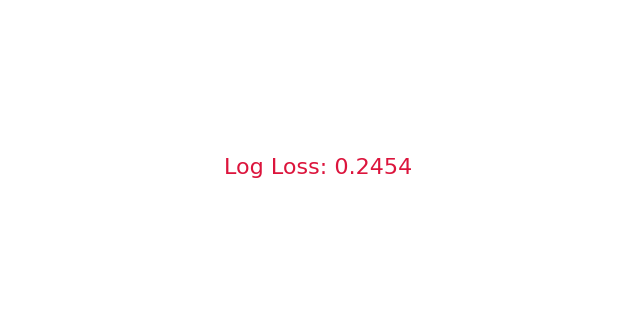

In [37]:

logloss = log_loss(y_test, pred)
plt.figure(figsize=(10, 5), facecolor="white")
plt.plot([])
plt.text(0, 0, f'Log Loss: {logloss:.4f}', fontsize=20, ha='center', va='center', color="crimson")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


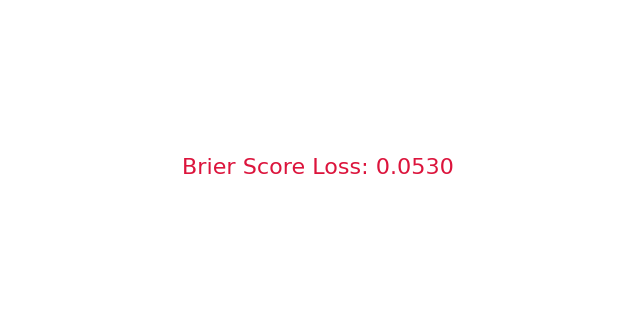

In [38]:
y_true_binary = [0 if label == 'food' else 1 for label in y_test]
brier_loss = brier_score_loss(y_true_binary, pred[:, 1].ravel())
plt.figure(figsize=(10, 5), facecolor="white")
plt.plot([])
plt.text(0, 0, f'Brier Score Loss: {brier_loss:.4f}', fontsize=20, ha='center', va='center', color="crimson")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


# Data Prediction

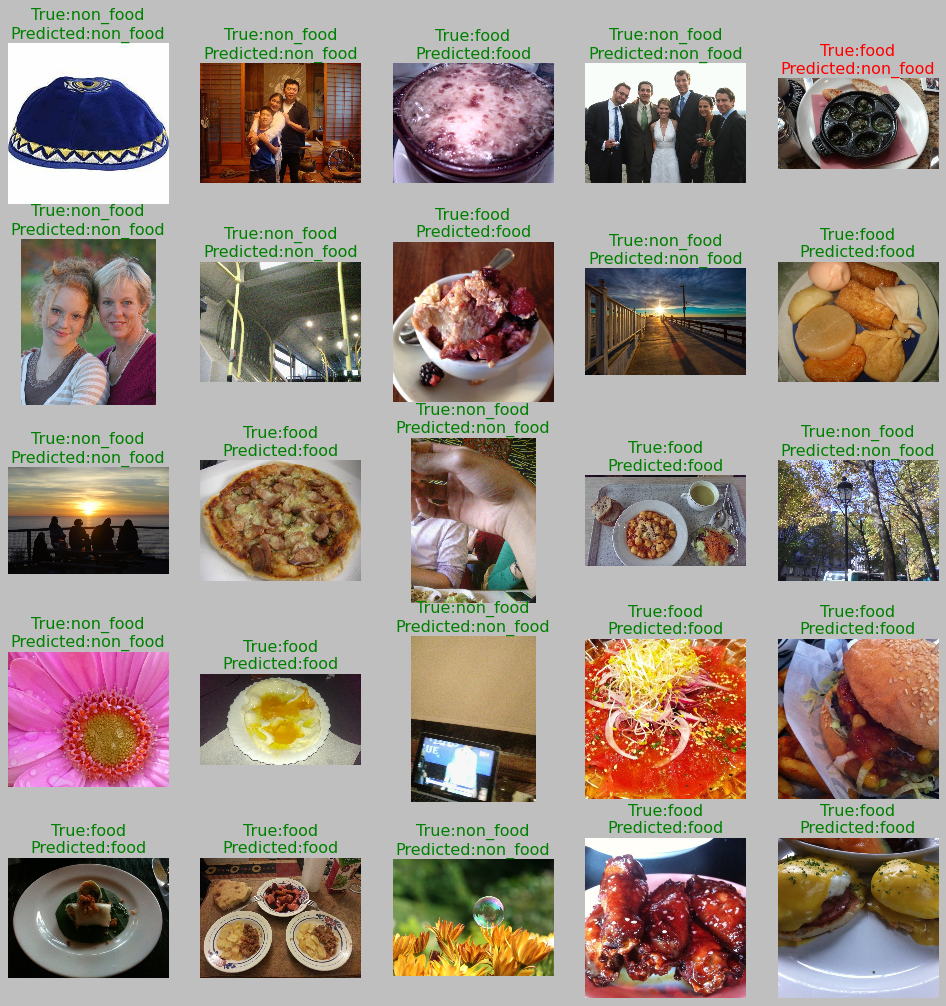

In [39]:
plt.figure(figsize=(15,15))
plt.style.use("classic")
number_images=(5,5)
for i in range(1,(number_images[0]*number_images[1])+1):
    plt.subplot(number_images[0],number_images[1],i)
    plt.axis("off")
    
    color="green"
    if final_test_data.label.iloc[i] !=final_predict[i]:
        color="red"
    plt.title(f"True:{final_test_data.label.iloc[i]}\nPredicted:{final_predict[i]}",color=color)
    plt.imshow(plt.imread(final_test_data['image_data'].iloc[i]))
    
plt.show()

# Custom data prediction

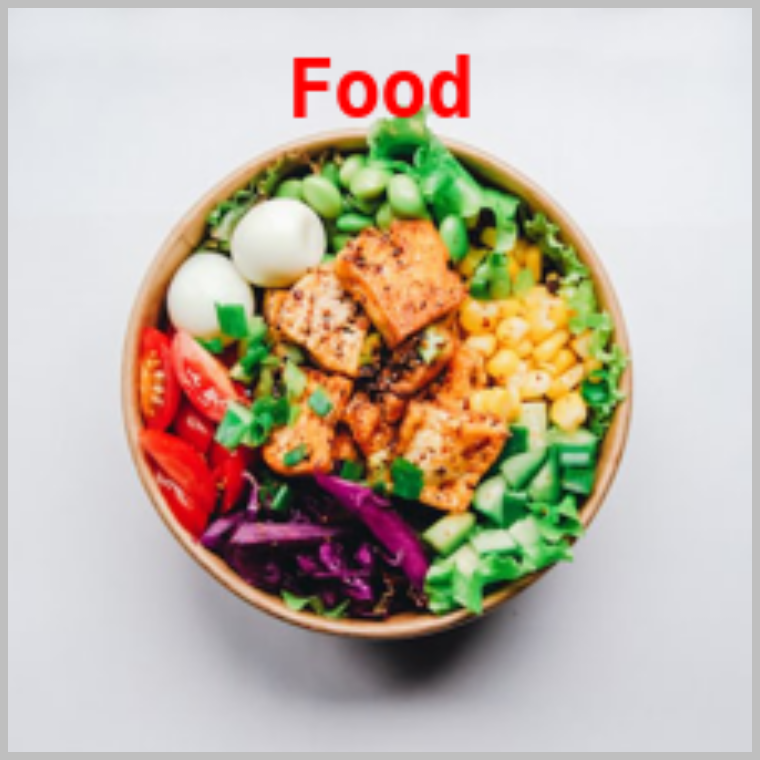

In [40]:
plt.style.use("classic")
image_url = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxleHBsb3JlLWZlZWR8Mnx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=400&q=60"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image_size = (224, 224)
image = image.resize(image_size)
image_np = np.array(image) / 255.0
# Expand dimensions to match the expected input shape of the model
image_np_expanded = np.expand_dims(image_np, axis=0)
prediction = model.predict(image_np_expanded)
final_prediction = np.argmax(prediction[0])
results = {0: 'Food', 1: 'Non Food'}
label = results[final_prediction]
draw = ImageDraw.Draw(image)
image_width, image_height = image.size
text = label
my_font = "/kaggle/input/hack-font/Hack-Bold.ttf"
font = ImageFont.truetype(my_font, 24)  

text_width, text_height = draw.textsize(text, font)
text_position = ((image_width - text_width) // 2, 10)
draw.text(text_position, text, fill=(255, 0, 0), font=font)
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis("off")
plt.show()


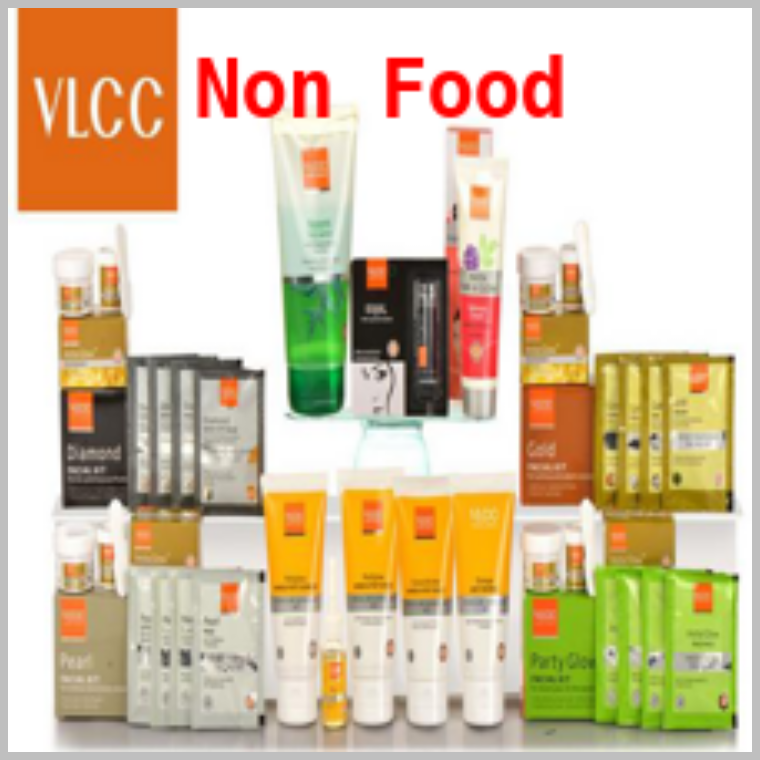

In [43]:
plt.style.use("classic")
image_url = "http://nebula.wsimg.com/92a64c559474090eb1be14acb79c1a26?AccessKeyId=FBAA582460EAC8C9DAAB&disposition=0&alloworigin=1"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image_size = (224, 224)
image = image.resize(image_size)
image_np = np.array(image) / 255.0
# Expand dimensions to match the expected input shape of the model
image_np_expanded = np.expand_dims(image_np, axis=0)
prediction = model.predict(image_np_expanded)
final_prediction = np.argmax(prediction[0])
results = {0: 'Food', 1: 'Non Food'}
label = results[final_prediction]
draw = ImageDraw.Draw(image)
image_width, image_height = image.size
text = label
my_font = "/kaggle/input/hack-font/Hack-Bold.ttf"
font = ImageFont.truetype(my_font, 24)  

text_width, text_height = draw.textsize(text, font)
text_position = ((image_width - text_width) // 2, 10)
draw.text(text_position, text, fill=(255, 0, 0), font=font)
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis("off")
plt.show()


![](https://allfreethankyounotes.com/wp-content/uploads/2023/05/all-free-thank-you-gif-1.gif)